In [14]:
from fancyimpute import SoftImpute, BiScaler, IterativeSVD,MatrixFactorization
import numpy as np
import csv
import pandas as pd
import copy
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from joshiboyd import *
from scipy.io import loadmat
from scipy.stats import norm, zscore

from sklearn import linear_model as lm
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings('ignore')


In [15]:
### set up some directory paths
proj_dir = os.path.abspath('../../')
data_dir = os.path.join(proj_dir, 'data')


In [16]:

def compute_d_prime(target, predicted):
    hits = np.sum((target == 1) & (predicted == 1))
    misses = np.sum((target == 1) & (predicted == 0))
    false_alarms = np.sum((target == 0) & (predicted == 1))
    correct_rejections = np.sum((target == 0) & (predicted == 0))
    
    n_hits = hits + 0.5
    n_false_alarms = false_alarms + 0.5
    n_trials = hits + misses + false_alarms + correct_rejections + 1
    
    HR = n_hits/(hits + misses)
    FAR = n_false_alarms / (false_alarms + correct_rejections)

    
    d_prime = norm.ppf(HR) - norm.ppf(FAR)

    
    return d_prime


### write a function to compute the jaccard-needham binary similarity between 2 boolean vectors

def jaccard_needham_similarity(x,y):
    x= x.astype(bool)
    y= y.astype(bool)
    """
    Computes the Jaccard-Needham similarity between two boolean vectors.
    """
    if np.sum(x) == 0 or np.sum(y) == 0:
        return 0
    else:
        return np.sum(x & y) / np.sum(x | y)
    
def k_highest_var_cols(M, k):
    col_vars = np.var(M, axis=0, ddof=0)
    sorted_cols = np.argsort(col_vars)[::-1] # Sort descending
    return sorted_cols[:k]

In [17]:
### read in the norm data

animal_fn = os.path.join(data_dir, 'LeuvenNorms/ANIMALSexemplarfeaturesbig.txt')
animal_df = pd.read_csv(animal_fn, sep='\t', header=0, index_col=0).reset_index().drop('FFrq',axis=1)
animal_df = animal_df.rename(columns={'feature/_exemplar_ENGLISH':'Item'})

tool_fn = os.path.join(data_dir, 'LeuvenNorms/ARTIFACTSexemplarfeaturesbig.txt')
### read in the file ARTIFACTSexemplarfeaturesbig.txt as a data frame and prevent the utf-8 encoding error
tool_df = pd.read_csv(tool_fn, sep='\t', header=0, index_col=0, encoding='latin-1').reset_index().drop('FFrq',axis=1)

print(f'We have {tool_df.shape[1]+animal_df.shape[1]-2} concepts in total')


# flan_df = pd.read_csv(os.path.join(data_dir,'flan_leuven_norms_overlap.csv'))
flan_df = pd.read_csv(os.path.join(data_dir,'flan_leuven_norms_with_spaces.csv'))

## stack animal_df dataframe and tool_df dataframe vertically making sure that common column names are shared between the two dataframes
animals = animal_df.columns[1:]
tools = tool_df.columns[1:]
merged_df = pd.merge(animal_df, tool_df, on='Item', how='outer')
leuven_concept_order = merged_df.columns[1:]
concept_sort_order = merged_df.columns.values

full_feat_array  = np.array(merged_df)[:,1:].T
full_feat_array = full_feat_array.astype(float)
full_feat_array = np.nan_to_num(full_feat_array, nan=0)
print(full_feat_array.shape)



# make all the values in column 'concept' lower case
# flan_df['concept'] = flan_df['concept'].str.lower()
flan_df=flan_df.sort_values(by='concept',key=lambda x: pd.Series(x).map(dict(zip(concept_sort_order, range(len(concept_sort_order))))))
feature_order = merged_df.Item.values
flan_df = flan_df[['concept']+list(feature_order)]
full_feat_array_flan = np.array(flan_df.iloc[:,1:]).astype(np.float)
print(full_feat_array_flan.shape)

We have 295 concepts in total
(295, 2026)
(295, 2026)


In [18]:
full_feat_array[full_feat_array<3] =0 
full_feat_array[full_feat_array>1] =1 
full_feat_array = np.nan_to_num(full_feat_array,nan=0)

full_concept_list = np.hstack([animals,tools])
(d1, d2) = full_feat_array.shape

distmat = pairwise_distances(full_feat_array, metric='cosine')
distman_flan = pairwise_distances(full_feat_array_flan, metric='cosine')

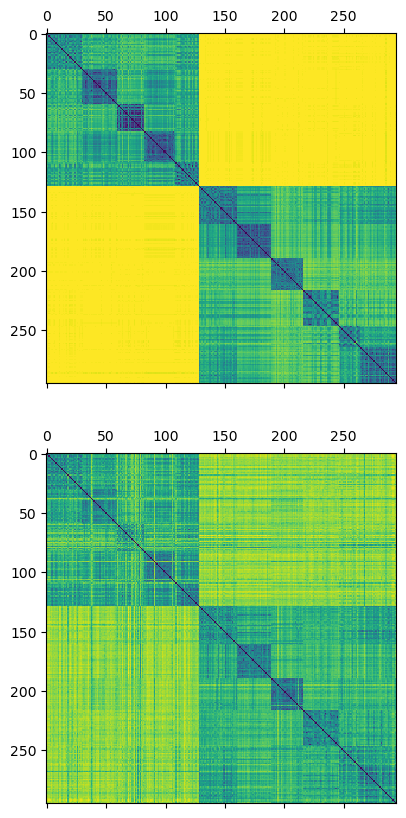

In [19]:
## let's look at our data
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].matshow(distmat)
### add the strings in full_concept_list as the x and y ticks
# axes[0].set_xticks(range(len(full_concept_list)), full_concept_list, rotation=90)
# axes[0].set_yticks(range(len(full_concept_list)), full_concept_list)

axes[1].matshow(distman_flan)
plt.show()

Text(0.5, 1.0, 'flan')

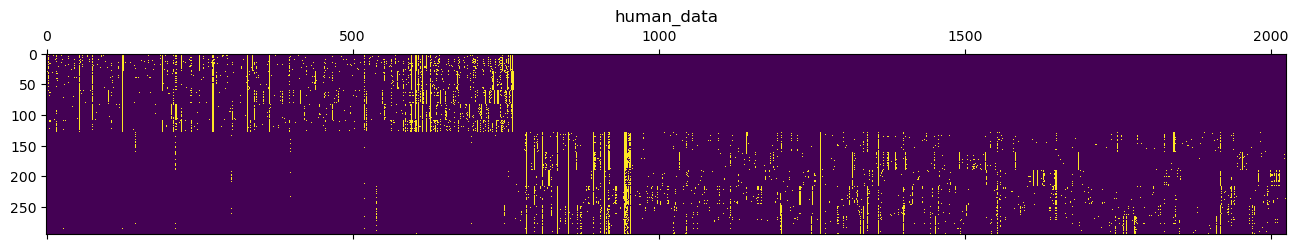

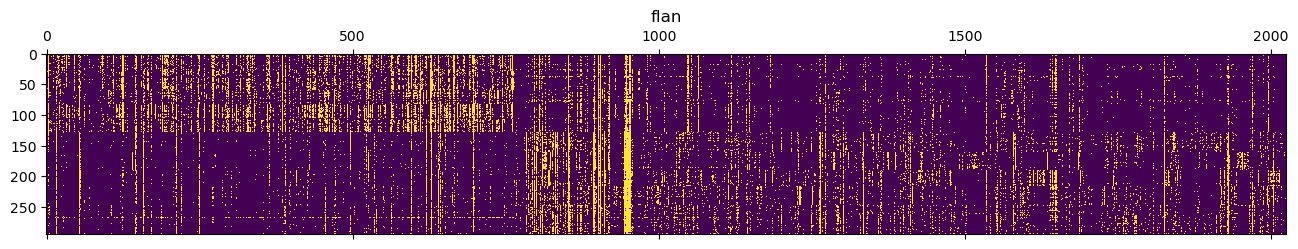

In [20]:
### original matrix
plt.matshow(full_feat_array)
plt.title('human_data')
plt.matshow(full_feat_array_flan)
plt.title('flan')

In [21]:
leuven_animal_array = full_feat_array[:129,:764]
leuven_tool_array = full_feat_array[129:,764:]

flan_animal_array = full_feat_array_flan[:129,:764]
flan_tool_array = full_feat_array_flan[129:,764:]


### New Concept Estimation

#### Leave one-out-approach

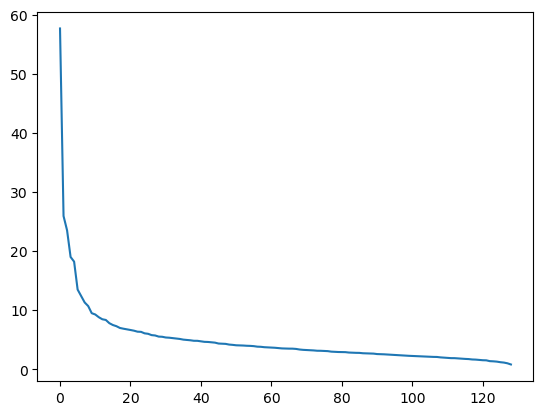

In [263]:

animal_u, animal_s, animal_v = np.linalg.svd(leuven_animal_array, full_matrices=False) ### do svd on the approx matrix

plt.plot(np.arange(animal_s.shape[0]),animal_s)

In [505]:


matrix_completion_dprimes=[]
baseline_flan_dprimes=[]
pred_vecs=[]
rank=10
for i in trange(leuven_animal_array.shape[0]):
    target_concept = leuven_animal_array[i,:] ### the concept to predict
    observed_array = np.delete(leuven_animal_array,i,axis=0) ### the array with the concept removed

    # observed_array_copy = copy.deepcopy(observed_array)
    # d1,d2 = observed_array_copy.shape

    # #    Choose dropout parameters
    # #   -------------------------

    # p_droptruepos   =   0.7 # probability of dropping a true positive value
    # p_droptrueneg   =   0.7 # probability of dropping a true negative (zero) value

    # #   Replace some entries with NaN's
    # #   -------------------------------

    # for row in range(d1):
    #     for col in range(d2):
    #         if observed_array_copy[row][col] == 1:
    #             if np.random.uniform(0,1) < p_droptruepos:
    #                 observed_array_copy[row][col] = np.NaN
               
    #         else:
    #             if np.random.uniform(0, 1) < p_droptrueneg:
    #                 observed_array_copy[row][col] = np.NaN
    
    # ### approximate matrix using iterativeSVD
    # isvd_obj = IterativeSVD(min_value=0, max_value=1,rank=40,verbose=False)
    
    # observed_array_approx = isvd_obj.fit_transform(observed_array_copy)

    # observed_array_approx = np.round(observed_array)
    
    col_means = np.nanmean(observed_array,axis=0)
    observed_array = observed_array - col_means
    

    animal_u, animal_s, animal_v = np.linalg.svd(observed_array, full_matrices=False) ### do svd on the approx matrix
    ## matrix multiply animal_s with animal_v
    animal_basis = np.diag(animal_s)@animal_v

    ### get the k columns with highest variance
    test_cols = k_highest_var_cols(observed_array,764)
                    
    ### use logistic regression to predict the target concept left singular vector from flan answwers
    if  np.sum(flan_animal_array[i,test_cols])==0:
       reg = lm.LogisticRegression(fit_intercept=False).fit(animal_basis.T[:,:rank],flan_animal_array[i,:])
    else:
        reg = lm.LogisticRegression(fit_intercept=False).fit(animal_basis.T[test_cols,:rank],flan_animal_array[i,test_cols])
    pred_animal_u_vec = reg.coef_
    pred_vec = pred_animal_u_vec@animal_basis[:rank,:] + col_means
    pred_vec = np.clip(np.round(pred_vec),0,1)
    pred_vecs.append(np.round(pred_vec))
    matrix_completion_dprimes.append(compute_d_prime(target_concept,pred_vec))
    baseline_flan_dprimes.append(compute_d_prime(target_concept,flan_animal_array[i,:]))


100%|██████████| 129/129 [00:05<00:00, 24.28it/s]


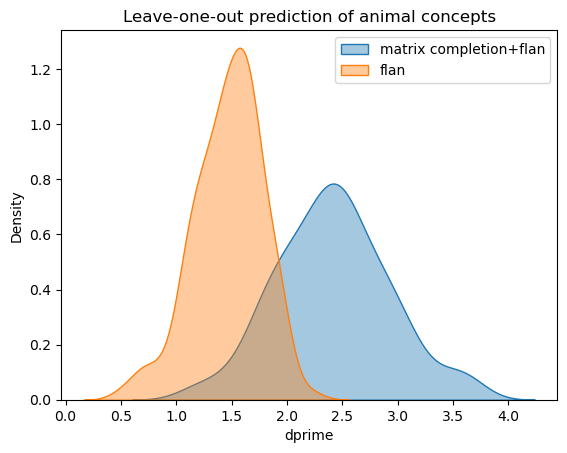

In [507]:
# plt.hist(baseline_flan_dprimes,label='flan', alpha=0.5,bins=15)
# plt.hist(matrix_completion_dprimes, label='matrix completion+flan', alpha=0.5, bins=15)

sns.kdeplot(matrix_completion_dprimes, label='matrix completion+flan', alpha=0.4, fill=True)
sns.kdeplot(baseline_flan_dprimes,label='flan', alpha=0.4, fill=True)
plt.xlabel('dprime')
plt.title('Leave-one-out prediction of animal concepts')
plt.legend()

plt.show()

In [296]:
### do a t-test to see if matrix completion is better than flan
from scipy import stats
recon_animal_array_clipped = np.vstack(pred_vecs_clipped)
recon_animal_array = np.vstack(pred_vecs)
matrix_completion_dprimes = np.array(matrix_completion_dprimes)
baseline_flan_dprimes = np.array(baseline_flan_dprimes)
matrix_completion_dprimes = matrix_completion_dprimes[~np.isnan(matrix_completion_dprimes)]
baseline_flan_dprimes = baseline_flan_dprimes[~np.isnan(baseline_flan_dprimes)]
stats.ttest_ind(matrix_completion_dprimes,baseline_flan_dprimes)


Ttest_indResult(statistic=18.076392243911734, pvalue=1.242034823613143e-47)

Text(0.5, 1.0, 'recon animal array')

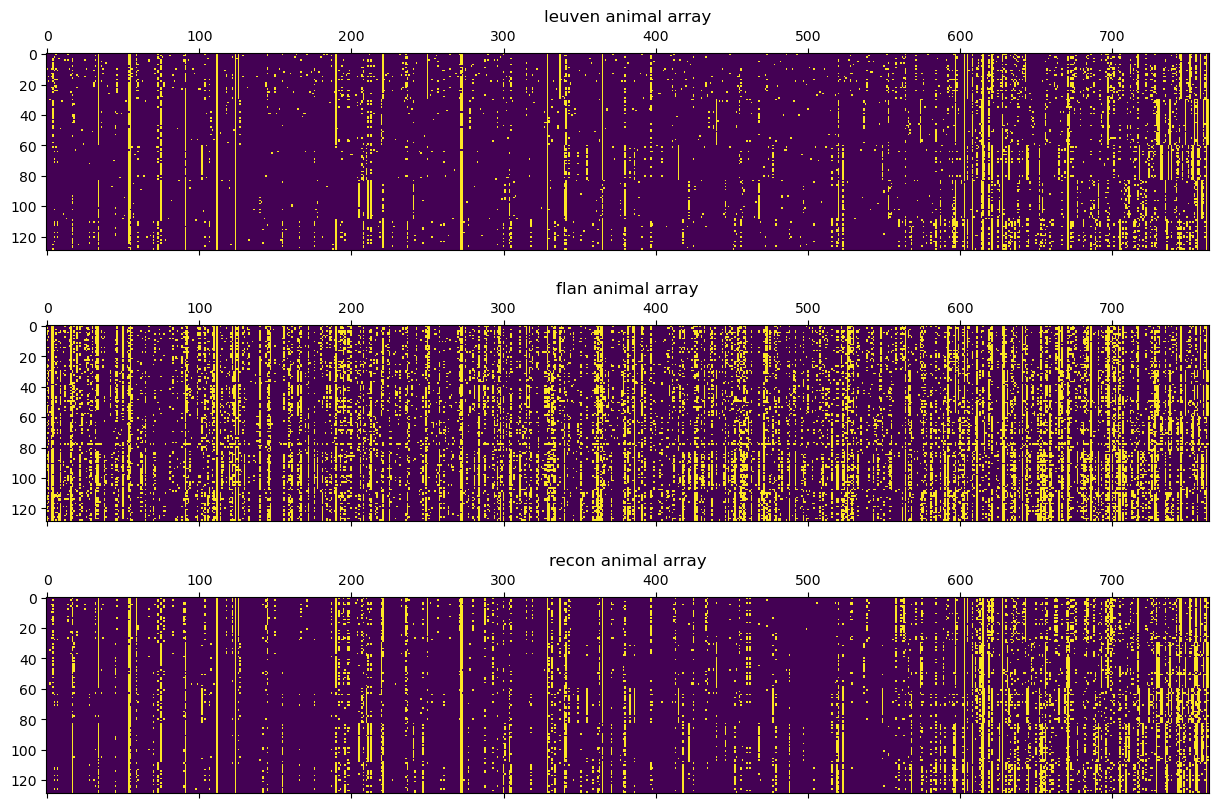

In [297]:



fig, axes = plt.subplots(3, 1, figsize=(15, 10))
### add the strings in full_concept_list as the x and y ticks
# axes[0].set_xticks(range(len(full_concept_list)), full_concept_list, rotation=90)
# axes[0].set_yticks(range(len(full_concept_list)), full_concept_list)


axes[0].matshow(leuven_animal_array)
axes[0].set_title('leuven animal array')

axes[1].matshow(flan_animal_array)
axes[1].set_title('flan animal array')

axes[2].matshow(recon_animal_array)
axes[2].set_title('recon animal array')

### Vary sample size

In [509]:


matrix_completion_dprimes=[]
baseline_flan_dprimes=[]
pred_vecs=[]
percent_witheld=[]
iters =[]
for iter in trange(200,desc='iter',leave=True):
    for percent in range(10,100,10):
        rank=np.minimum(10,leuven_animal_array.shape[0]-int(percent/100*leuven_animal_array.shape[0]))

        sampled_concepts =  np.random.choice(np.arange(leuven_animal_array.shape[0]), int((percent/100)*leuven_animal_array.shape[0]), replace=False)
        target_concept = leuven_animal_array[sampled_concepts,:] ### the concept to predict
        observed_array = np.delete(leuven_animal_array,sampled_concepts,axis=0) ### the array with the concept removed

        # observed_array_copy = copy.deepcopy(observed_array)
        # d1,d2 = observed_array_copy.shape

        # #    Choose dropout parameters
        # #   -------------------------

        # p_droptruepos   =   0.7 # probability of dropping a true positive value
        # p_droptrueneg   =   0.7 # probability of dropping a true negative (zero) value

        # #   Replace some entries with NaN's
        # #   -------------------------------

        # for row in range(d1):
        #     for col in range(d2):
        #         if observed_array_copy[row][col] == 1:
        #             if np.random.uniform(0,1) < p_droptruepos:
        #                 observed_array_copy[row][col] = np.NaN
                
        #         else:
        #             if np.random.uniform(0, 1) < p_droptrueneg:
        #                 observed_array_copy[row][col] = np.NaN
        
        # ### approximate matrix using iterativeSVD
        # isvd_obj = IterativeSVD(min_value=0, max_value=1,rank=40,verbose=False)
        
        # observed_array_approx = isvd_obj.fit_transform(observed_array_copy)

        # observed_array_approx = np.round(observed_array)
        col_means = np.nanmean(observed_array,axis=0)
        observed_array = observed_array - col_means
        

        animal_u, animal_s, animal_v = np.linalg.svd(observed_array, full_matrices=False) ### do svd on the approx matrix
        ## matrix multiply animal_s with animal_v
        animal_basis = np.diag(animal_s)@animal_v

        ### get the k columns with highest variance
        test_cols = k_highest_var_cols(observed_array,764)
        pred_animal_u_vec = np.zeros((len(sampled_concepts),rank))
        for i in range(len(sampled_concepts)):
                            
            ### use logistic regression to predict the target concept left singular vector from flan answwers
            if  np.sum(flan_animal_array[sampled_concepts[i],test_cols])==0:
                reg = lm.LogisticRegression(fit_intercept=False).fit(animal_basis.T[:,:rank],flan_animal_array[sampled_concepts[i],:])
            else:
                reg = lm.LogisticRegression(fit_intercept=False).fit(animal_basis.T[test_cols,:rank],flan_animal_array[sampled_concepts[i],test_cols])
            pred_animal_u_vec[i, :] = reg.coef_
            pred_vec = reg.coef_@animal_basis[:rank,:] + col_means
            pred_vec = np.clip(np.round(pred_vec),0,1)
            pred_vecs.append(np.round(pred_vec))
            percent_witheld.append(percent)
            matrix_completion_dprimes.append(compute_d_prime(target_concept[i],pred_vec))
            baseline_flan_dprimes.append(compute_d_prime(target_concept[i],flan_animal_array[sampled_concepts[i],:]))
            iters.append(iter)

        # pred_vec = pred_animal_u_vec@animal_basis[:rank,:] + col_means
        # pred_vec = np.clip(np.round(pred_vec),0,1)
        # pred_vecs.append(np.round(pred_vec))
        # percent_witheld.append(percent)
        # matrix_completion_dprimes.append(compute_d_prime(target_concept,pred_vec))
        # baseline_flan_dprimes.append(compute_d_prime(target_concept,flan_animal_array[sampled_concepts,:]))
        # iters.append(iter)
    # break


iter: 100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


In [510]:
gt_dprimes = []
for i in range(leuven_animal_array.shape[0]):
    gt_dprimes.append(compute_d_prime(leuven_animal_array[i,:],flan_animal_array[i,:]))



In [511]:
plotting_df

,dprime_flan,dprime_mc,percent_witheld,iter
0,0.906016,1.809114,10,0
1,1.939557,2.657273,10,0
2,1.454312,2.751035,10,0
3,0.514261,1.521305,10,0
4,1.706610,2.414069,10,0
...,...,...,...,...
115195,1.041919,1.770727,90,199
115196,1.545190,1.667063,90,199
115197,1.713121,1.420967,90,199
115198,1.336311,1.883540,90,199


In [512]:
# plt.hist(baseline_flan_dprimes,label='flan', alpha=0.5,bins=15)
# plt.hist(matrix_completion_dprimes, label='matrix completion+flan', alpha=0.5, bins=15)

# # sns.kdeplot(matrix_completion_dprimes, label='matrix completion+flan', alpha=0.5)
# # sns.kdeplot(baseline_flan_dprimes,label='flan', alpha=0.5)
# plt.xlabel('dprime')
# plt.legend()
# plt.show()

100%|██████████| 9/9 [00:00<00:00, 17.14it/s]


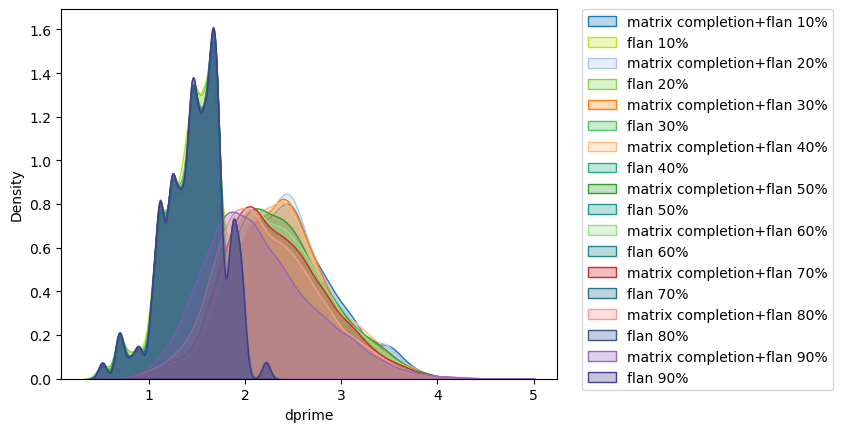

In [513]:
plotting_df = pd.DataFrame({'dprime_flan': baseline_flan_dprimes ,'dprime_mc':matrix_completion_dprimes,'percent_witheld':percent_witheld,'iter':iters})
plotting_df['dprime_mc'] = plotting_df['dprime_mc'].fillna(plotting_df['dprime_mc'].max())
### load the tableau20 colors using seaborn and store in a variable called tab20
tab20 = sns.color_palette('tab20')
viridis_r = sns.color_palette('viridis_r',10)
magma_r = sns.color_palette('magma_r',10)


### plot separate histograms for each percent withheld but show them overlapping in a single plot
for i,percent in enumerate(trange(10,100,10)):

    sns.kdeplot(plotting_df[plotting_df.percent_witheld==percent]['dprime_mc'], label=f'matrix completion+flan {percent}%', alpha=0.3, fill=True, color = tab20[i])
    sns.kdeplot(plotting_df[plotting_df.percent_witheld==percent]['dprime_flan'], label=f'flan {percent}%', alpha=0.3, fill=True,color =viridis_r[i] )

    
    # sns.histplot(plotting_df[plotting_df.percent_witheld==percent]['dprime_mc'], label=f'matrix completion+flan {percent}%', alpha=0.4, fill=True, element='step', binwidth=.03, color = tab20[i])
    # sns.histplot(plotting_df[plotting_df.percent_witheld==percent]['dprime_flan'], label=f'flan {percent}%', alpha=0.4, fill=True, element='step', binwidth=.03,color =viridis_r[i] )
   
    plt.xlabel('dprime')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.show()





100%|██████████| 9/9 [00:00<00:00, 32.33it/s]


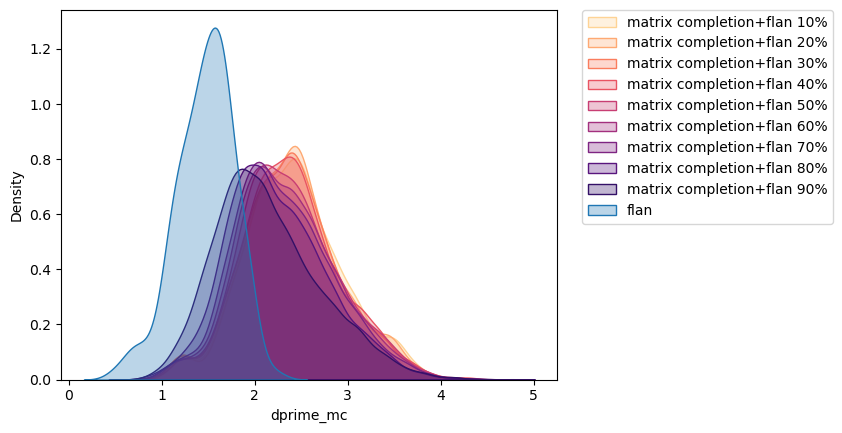

In [514]:
for i,percent in enumerate(trange(10,100,10)):
    sns.kdeplot(plotting_df[plotting_df.percent_witheld==percent]['dprime_mc'], label=f'matrix completion+flan {percent}%', alpha=0.3, fill=True,  color = magma_r[i])
sns.kdeplot(x=gt_dprimes, alpha=0.3, label='flan',fill=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


# sns.histplot(data = plotting_df, x='dprime_mc', hue= 'percent_witheld', alpha=0.4, fill=True, palette='viridis',element='step',ax=ax)

# sns.histplot(x=gt_dprimes, alpha=0.4, label='flan',fill=True, binwidth=.04, element='step',ax=ax)

# # sns.kdeplot(data= plotting_df, x='dprime_flan', hue='percent_witheld', label=f'flan {percent}%', alpha=0.4, fill=True, palette='viridis')




# ax.set_xlabel('dprime')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [515]:
stats.ttest_ind(plotting_df[plotting_df.percent_witheld==90]['dprime_mc'],gt_dprimes)

Ttest_indResult(statistic=13.332849846447434, pvalue=2.0962132269735703e-40)

(13, 764)

90